In [242]:
import json
from pathlib import Path
from itertools import islice
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

In [243]:
#Load json.
def load_dataset(path: Path):
    with open(path, 'r') as data_file:
        for line in data_file:
            yield json.loads(line)
        

In [244]:
#Import data
LuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/Luxury_Beauty.json'))
mLuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/meta_Luxury_Beauty.json'))
PrimePantry = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Prime_Pantry/Prime_Pantry.json'))
mPrimePantry = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Prime_Pantry/meta_Prime_Pantry.json'))

In [245]:
#Format Data as DataFrame
LuxuryB = pd.DataFrame(LuxuryB)
mLuxuryB = pd.DataFrame(mLuxuryB)
Prime = pd.DataFrame(PrimePantry)
mPrime = pd.DataFrame(mPrimePantry)

In [246]:
#Tidy the data for Luxury Beauty
LuxuryB = LuxuryB.loc[:, ['asin', 'overall', 'reviewTime','verified']]

#Only select the data where the verified purchase is Ture.
LuxuryBT = LuxuryB[LuxuryB['verified'] == True]
LuxuryBT.drop(['verified'], axis = 1, inplace = True)

mLuxuryB = mLuxuryB.loc[:, ['asin', 'title', 'price', 'brand', 'main_cat']]
DF1 = pd.merge(LuxuryBT, mLuxuryB, how = "inner", on = "asin")
DF1['reviewTime'] = pd.to_datetime(DF1.reviewTime)

In [247]:
# Redefine the brand by using the first name of the title
##Please Note that the brand called 'var' might be the result for the titles which are unable to show the actual names.
##We would still consider it, however it might be the sum for all products which don't have a proper title.
# new data frame with split value columns 
new = DF1["title"].str.split(" ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
DF1["brand"]= new[0] 

In [248]:
#Tidy the data for Prime Pantry
Prime = Prime.loc[:, ['asin', 'overall', 'reviewTime','verified']]
#Only select the data where the verified purchase is Ture.
PrimeT = Prime[Prime['verified'] == True]
PrimeT.drop(['verified'], axis = 1, inplace = True)

mPrime = mPrime.loc[:, ['asin', 'title', 'price', 'brand', 'main_cat']]
DF2 = pd.merge(PrimeT, mPrime, how = "inner", on = "asin")
DF2['reviewTime'] = pd.to_datetime(DF2.reviewTime)
DF2['main_cat'].fillna('Prime Pantry', inplace=True)

/Users/linxisarah/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [249]:
#Just a reminder here
if PrimeT.shape[0] < DF2.shape[0]:
    print("Some reviews are of products are not in the metadata")

Some reviews are of products are not in the metadata


In [250]:
#Set-up the time range
def add_first_review_time(data):
    min_review_time = min(data['reviewTime'])
    max_review_time = max(data['reviewTime'])
    data['firstReviewTime'] = min_review_time
    if ((max_review_time - min_review_time) / np.timedelta64(1, 'M')) >= 6:
        reviewed_by_at_least_six_motnths = True
    else:
        reviewed_by_at_least_six_motnths = False
    data['reviewedByAtLeastSixMotnths'] = reviewed_by_at_least_six_motnths
    return data

In [251]:
DF1 = DF1.groupby('asin').apply(add_first_review_time)
DF2 = DF2.groupby('asin').apply(add_first_review_time)

In [252]:
DF1['numMonthsSinceFirstReview'] = ((DF1['reviewTime'] - DF1['firstReviewTime']) / np.timedelta64(1, 'M')).astype(int)
DF2['numMonthsSinceFirstReview'] = ((DF2['reviewTime'] - DF2['firstReviewTime']) / np.timedelta64(1, 'M')).astype(int)

In [253]:
#Select the products which have been reviewed more than 6 month and only take the data for the first 6 month.
DF1x = DF1[(DF1['reviewedByAtLeastSixMotnths'] == True) & (DF1['numMonthsSinceFirstReview'] < 6)]
DF2x = DF2[(DF2['reviewedByAtLeastSixMotnths'] == True) & (DF2['numMonthsSinceFirstReview'] < 6)]

In [254]:
#Count the frequency of reviews in each month for each product
DF2_Count = DF2x.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF1_Count = DF1x.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")

In [255]:
#Calculate the mean value of review of each month
DF1_Count.loc[:, 'MonthSum'] = DF1_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.sum)
DF1_Count.loc[:, 'Mean'] = DF1_Count['MonthSum']/len(DF1_Count.brand.unique())
DF1_Count['Mean'] = round(DF1_Count['Mean'], 1)


DF2_Count.loc[:, 'MonthSum'] = DF2_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.sum)
DF2_Count.loc[:, 'Mean'] = DF2_Count['MonthSum']/len(DF2_Count.brand.unique())
DF2_Count['Mean'] = round(DF2_Count['Mean'], 1)

In [256]:
DF1_Count['Cat'] = 'Luxury Beauty'
DF2_Count['Cat'] = 'Prime Pantry'

P1_D = pd.concat([DF1_Count,DF2_Count])
P1_D = P1_D[['numMonthsSinceFirstReview','Mean', 'Cat']]
P1_D = P1_D.drop_duplicates(['numMonthsSinceFirstReview','Mean', 'Cat'])
P1_D.sort_values('numMonthsSinceFirstReview', inplace=True)
P1_D.reset_index(inplace=True)
P1_D.drop("index", axis=1, inplace=True)
P1_D = P1_D.pivot(index='numMonthsSinceFirstReview', columns='Cat', values='Mean')
P1_D.reset_index(inplace=True)

In [257]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [262]:
#Dataset for Price
DF1_Price = DF1x.groupby(["asin", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
Price1 = DF1x[['asin','price']]
Price1 = Price1.drop_duplicates(['asin','price'])
DF1_Price = pd.merge(Price1, DF1_Price, how = "inner", on = "asin")
DF1_Price['Cat'] = 'Luxury Beauty'


DF2_Price = DF2x.groupby(["asin", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
Price2 = DF2x[['asin','price']]
Price2 = Price2.drop_duplicates(['asin','price'])
DF2_Price = pd.merge(Price2, DF2_Price, how = "inner", on = "asin")
DF2_Price['Cat'] = 'Prime Pantry'

DF_Price = pd.concat([DF1_Price, DF2_Price])
DF_Price.reset_index(inplace = True)
DF_Price.drop('index', axis=1, inplace = True)

In [264]:
DF_Price.dropna(inplace = True) 
# new data frame with split value columns 
new = DF_Price["price"].str.split("$", n = 1, expand = True) 
  
# making separate first name column from new data frame 
DF_Price["price"]= new[1] 

#Change price from string format to numerical format
DF_Price['price'] = pd.to_numeric(DF_Price['price'], errors='coerce')

DF_Price.loc[:, 'Price_Range'] = DF_Price.groupby(['Cat'])['price'].transform(lambda x: np.where(x > np.quantile(x, 0.75), 'High', 
         (np.where(x < np.quantile(x, 0.25), 'Low', 'Medium'))))

DF_Price

,asin,price,numMonthsSinceFirstReview,Count,Cat
0,B00004U9V2,30.00,0,2,Luxury Beauty
1,B00004U9V2,30.00,5,2,Luxury Beauty
2,B00005A77F,15.99,0,2,Luxury Beauty
3,B00005A77F,15.99,5,2,Luxury Beauty
4,B00005NDTD,18.00,0,2,Luxury Beauty
...,...,...,...,...,...
49724,B01HI76EWA,7.96,4,1,Prime Pantry
49725,B01HI76EWA,7.96,5,1,Prime Pantry
49726,B01HI8JVI8,6.82,0,1,Prime Pantry
49727,B01HI8JVI8,6.82,1,1,Prime Pantry


In [266]:
#len(DF_Price.asin.unique())
Products = DF_Price.groupby(['Cat',"Price_Range"])['asin'].transform(lambda x: len(x.unique()))
Products = pd.DataFrame(Products)
Products = Products.drop_duplicates(['asin'])

#Match Data
Products = pd.merge(Products, DF_Price, left_index = True, right_index = True)
Products.rename({'asin_x': 'Sum_of_asin'}, axis=1, inplace=True)
Products = Products[['Cat','Price_Range','Sum_of_asin']]

Products

,Cat,Price_Range,Sum_of_asin
0,Luxury Beauty,Medium,3051
2,Luxury Beauty,Low,1383
9,Luxury Beauty,High,1449
20184,Prime Pantry,Low,1319
20228,Prime Pantry,Medium,3143
20234,Prime Pantry,High,1675


In [267]:
DF_Price

,asin,price,numMonthsSinceFirstReview,Count,Cat,Price_Range
0,B00004U9V2,30.00,0,2,Luxury Beauty,Medium
1,B00004U9V2,30.00,5,2,Luxury Beauty,Medium
2,B00005A77F,15.99,0,2,Luxury Beauty,Low
3,B00005A77F,15.99,5,2,Luxury Beauty,Low
4,B00005NDTD,18.00,0,2,Luxury Beauty,Low
...,...,...,...,...,...,...
49724,B01HI76EWA,7.96,4,1,Prime Pantry,Medium
49725,B01HI76EWA,7.96,5,1,Prime Pantry,Medium
49726,B01HI8JVI8,6.82,0,1,Prime Pantry,Medium
49727,B01HI8JVI8,6.82,1,1,Prime Pantry,Medium


In [269]:
DF_Price['CountSum'] = DF_Price.groupby(["Price_Range", "numMonthsSinceFirstReview", 
                                         'Cat'])['Count'].transform(np.sum)

DF_Price

,asin,price,numMonthsSinceFirstReview,Count,Cat,Price_Range,CountSum
0,B00004U9V2,30.00,0,2,Luxury Beauty,Medium,4173
1,B00004U9V2,30.00,5,2,Luxury Beauty,Medium,1437
2,B00005A77F,15.99,0,2,Luxury Beauty,Low,2287
3,B00005A77F,15.99,5,2,Luxury Beauty,Low,1153
4,B00005NDTD,18.00,0,2,Luxury Beauty,Low,2287
...,...,...,...,...,...,...,...
49724,B01HI76EWA,7.96,4,1,Prime Pantry,Medium,3818
49725,B01HI76EWA,7.96,5,1,Prime Pantry,Medium,3928
49726,B01HI8JVI8,6.82,0,1,Prime Pantry,Medium,5525
49727,B01HI8JVI8,6.82,1,1,Prime Pantry,Medium,2982


In [282]:
DF_Price['CountSum'] = DF_Price.groupby(["Price_Range", "numMonthsSinceFirstReview", 'Cat'])['Count'].transform(np.sum)
DF_PriceRange = DF_Price[['Price_Range','Cat','numMonthsSinceFirstReview','CountSum']]
DF_PriceRange = DF_PriceRange.drop_duplicates(['Price_Range','Cat','numMonthsSinceFirstReview','CountSum'])
DF_PriceRange = pd.DataFrame(DF_PriceRange)
DF_PriceRange = pd.merge(DF_PriceRange, Products, on=['Cat', 'Price_Range'])

DF_PriceRange['Mean'] = DF_PriceRange['CountSum']/DF_PriceRange['Sum_of_asin']
DF_PriceRange

,Price_Range,Cat,numMonthsSinceFirstReview,CountSum,Sum_of_asin,Mean
0,Medium,Luxury Beauty,0,4173,3051,1.367748
1,Medium,Luxury Beauty,5,1437,3051,0.470993
2,Medium,Luxury Beauty,2,1278,3051,0.418879
3,Medium,Luxury Beauty,1,1187,3051,0.389053
4,Medium,Luxury Beauty,4,1397,3051,0.457883
5,Medium,Luxury Beauty,3,1311,3051,0.429695
6,Low,Luxury Beauty,0,2287,1383,1.653651
7,Low,Luxury Beauty,5,1153,1383,0.833695
8,Low,Luxury Beauty,1,846,1383,0.611714
9,Low,Luxury Beauty,2,964,1383,0.697035


In [283]:
P2_D = DF_PriceRange.groupby('Cat').apply(lambda x: x.pivot(index ='numMonthsSinceFirstReview', 
                                                columns= 'Price_Range', values='Mean'))

P2_D.reset_index(inplace = True)
P2_D

Price_Range,Cat,numMonthsSinceFirstReview,High,Low,Medium
0,Luxury Beauty,0,1.427191,1.653651,1.367748
1,Luxury Beauty,1,0.444444,0.611714,0.389053
2,Luxury Beauty,2,0.419600,0.697035,0.418879
3,Luxury Beauty,3,0.440994,0.683297,0.429695
4,Luxury Beauty,4,0.458247,0.821403,0.457883
5,Luxury Beauty,5,0.487233,0.833695,0.470993
6,Prime Pantry,0,1.616119,1.917362,1.757875
7,Prime Pantry,1,0.712239,1.097043,0.948775
8,Prime Pantry,2,0.867463,1.391205,1.097996
9,Prime Pantry,3,0.889552,1.438969,1.113904


In [284]:
len(DF2[DF2['reviewTime'] <= '2014-01-01'])/len(DF2)

0.04603714223747096

In [285]:
len(DF1[DF1['reviewTime'] <= '2014-01-01'])/len(DF1)

0.1361572484553653

In [288]:
#Prime Pantry srvices starts in 2014 therefore we decided to look at the data in the past five years
DF1T = DF1[DF1['reviewTime'] >= '2014-01-01']
DF1T['Year'] = DF1T['reviewTime'].dt.year

DF2T = DF2[DF2['reviewTime'] >= '2014-01-01']
DF2T['Year'] = DF2T['reviewTime'].dt.year

/Users/linxisarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linxisarah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [289]:
DF_Score = pd.concat([DF1T, DF2T])
DF_Score = DF_Score[['Year','main_cat','overall']]
DF_Score

,Year,main_cat,overall
4,2018,Luxury Beauty,5.0
5,2018,Luxury Beauty,5.0
6,2018,Luxury Beauty,5.0
7,2018,Luxury Beauty,5.0
8,2018,Luxury Beauty,5.0
...,...,...,...
382686,2017,Prime Pantry,5.0
382687,2017,Prime Pantry,5.0
382688,2017,Prime Pantry,5.0
382689,2017,Prime Pantry,5.0


In [290]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [291]:
DF_ScoreReview = DF_Score.groupby(['Year','main_cat','overall']).size().reset_index(name = "ScoreSum")
DF_ScoreReview['YearSum'] = DF_ScoreReview.groupby(['Year','main_cat'])['ScoreSum'].transform(np.sum)
DF_ScoreReview['Percentage'] = DF_ScoreReview['ScoreSum']/DF_ScoreReview['YearSum']

In [292]:
P4_D = DF_ScoreReview.drop(['ScoreSum','YearSum'], axis = 1)
P4_D = P4_D.groupby('main_cat').apply(lambda x: x.pivot(index ='Year', 
                                                columns= 'overall', values='Percentage'))
P4_D.reset_index(inplace = True)
P4_D.rename({1.0: 'Score1',2.0:'Score2',3.0:'Score3',4.0:'Score4',5.0:'Score5'}, axis=1, inplace=True)

In [293]:
P4_D1 = P4_D[P4_D['main_cat'] == 'Luxury Beauty']
P4_D2 = P4_D[P4_D['main_cat'] == 'Prime Pantry']

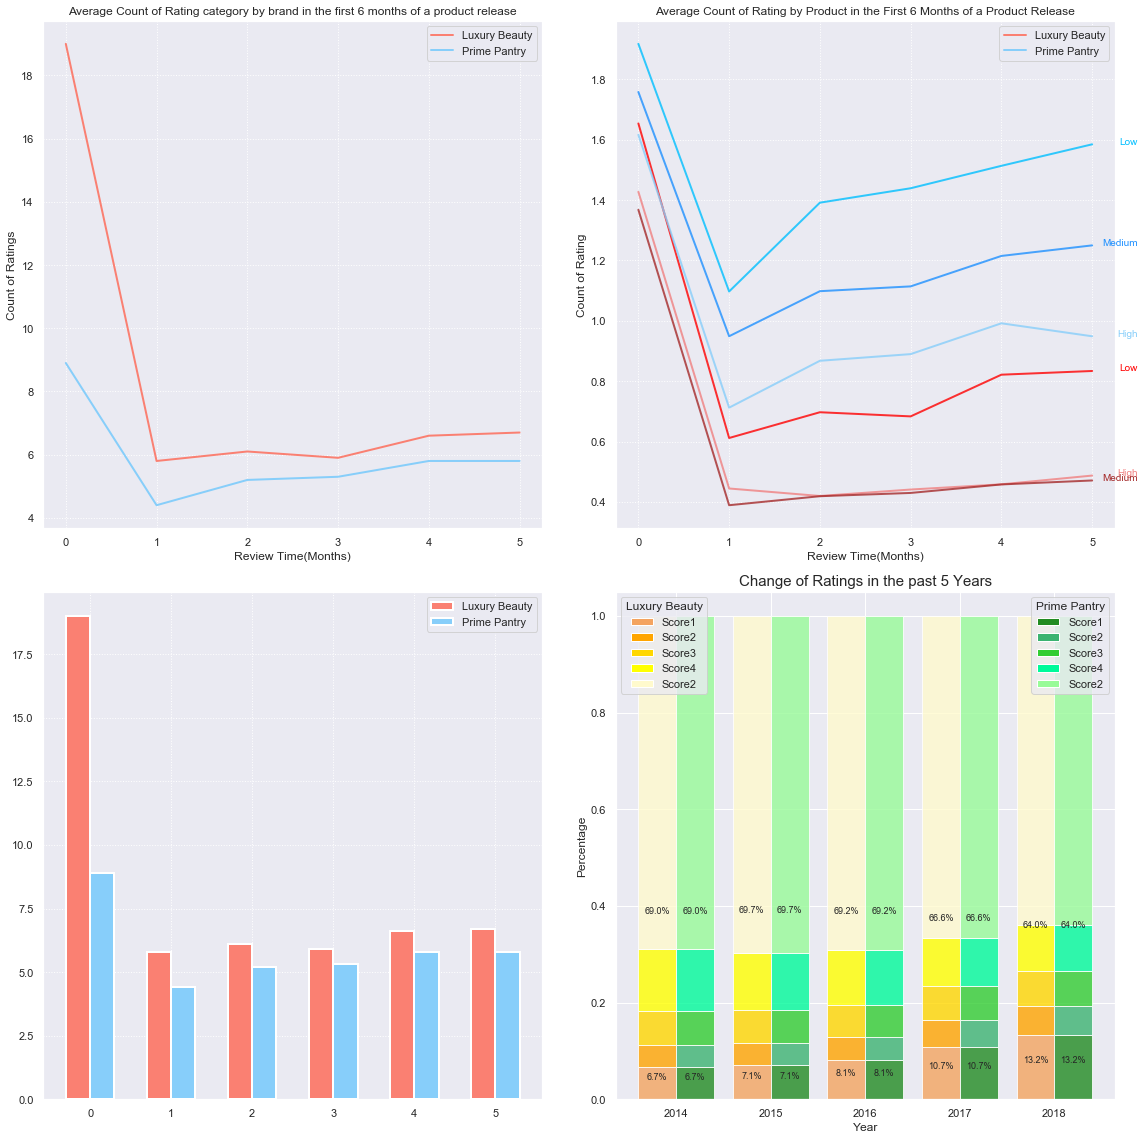

In [296]:
fig = plt.figure(figsize=(16, 16))

# add chart
AX0 = fig.add_subplot(2, 2, 1)
AX1 = fig.add_subplot(2, 2, 2)
AX2 = fig.add_subplot(2, 2, 3)
AX3 = fig.add_subplot(2, 2, 4)


AX0.grid(linestyle=":", linewidth=1)

AX0.plot(P1_D['numMonthsSinceFirstReview'], P1_D['Luxury Beauty'], marker='', 
         color='salmon', linewidth=2, alpha = 1, label='Luxury Beauty')

AX0.plot(P1_D['numMonthsSinceFirstReview'], P1_D['Prime Pantry'], marker='', 
         color='lightskyblue', linewidth=2, alpha = 1, label = 'Prime Pantry')

AX0.legend(loc='best')

## Add titles
AX0.set_title("Average Count of Rating category by brand in the first 6 months of a product release", 
              fontsize=12, fontweight=0)
AX0.set_xlabel('Review Time(Months)')
AX0.set_ylabel('Count of Ratings')


#AX1
AX1.grid(linestyle=":", linewidth=1)
P2_D1 = P2_D[P2_D['Cat'] == 'Luxury Beauty']
P2_D2 = P2_D[P2_D['Cat'] == 'Prime Pantry']

palette1 = ['lightcoral', 'red','brown']
palette2 = ['lightskyblue','deepskyblue','dodgerblue']

# multiple line plot
num=0
for column in P2_D1.drop(['Cat','numMonthsSinceFirstReview'], axis=1):
   num+=1
   AX1.plot(P2_D1['numMonthsSinceFirstReview'], P2_D1[column], marker='', 
             color = palette1[num-1], linewidth=2, alpha=0.8)

num=0
for column in P2_D2.drop(['Cat','numMonthsSinceFirstReview'], axis=1):
   num+=1
   AX1.plot(P2_D2['numMonthsSinceFirstReview'], P2_D2[column], marker='', color = palette2[num-1], linewidth=2, alpha=0.8)

num=0
for i in P2_D1.values[5][1:]:
   num+=1
   name=list(P2_D1)[num]
   if name != 'numMonthsSinceFirstReview':
      AX1.text(5.5, i, name, size='small', horizontalalignment='right', color = palette1[num-2])

num=0
for i in P2_D2.values[5][1:]:
   num+=1
   name=list(P2_D2)[num]
   if name != 'numMonthsSinceFirstReview':
      AX1.text(5.5, i, name, size='small', horizontalalignment='right', color = palette2[num-2])

legend_elements = [Line2D([0], [0], color='salmon', lw=2, label='Luxury Beauty'),
                   Line2D([0], [0], color='lightskyblue', lw=2, label='Prime Pantry')]

AX1.legend(handles=legend_elements, loc='best')

## Add titles
AX1.set_title("Average Count of Rating by Product in the First 6 Months of a Product Release", 
              fontsize=12, fontweight=0)
AX1.set_xlabel('Review Time(Months)')
AX1.set_ylabel('Count of Rating')


#Alternative for AX0
AX2.grid(linestyle=":", linewidth=1)

AX2.bar(P1_D['numMonthsSinceFirstReview']-0.15, P1_D['Luxury Beauty'],
         color='salmon', linewidth=2, alpha = 1, label='Luxury Beauty', width = 0.3)

AX2.bar(P1_D['numMonthsSinceFirstReview']+0.15, P1_D['Prime Pantry'],
         color='lightskyblue', linewidth=2, alpha = 1, label = 'Prime Pantry', width = 0.3)

AX2.legend()

rects1 = AX3.bar( P4_D1['Year']-0.2, P4_D1['Score1'], 
                 color='sandybrown', edgecolor='white', alpha = 0.8, width=0.4)

rects2 = AX3.bar( P4_D1['Year']-0.2, P4_D1['Score2'], 
                 color='orange', edgecolor='white', bottom=P4_D1['Score1'], alpha = 0.8, width=0.4)

rects3 = AX3.bar( P4_D1['Year']-0.2, P4_D1['Score3'], 
                 color='gold', edgecolor='white', bottom=[sum(i) for i in zip(P4_D1['Score1'], P4_D1['Score2'])], 
                 alpha = 0.8, width=0.4)

rects4 = AX3.bar( P4_D1['Year']-0.2, P4_D1['Score4'], 
                 color='yellow', edgecolor='white', 
                 bottom=[sum(i) for i in zip(P4_D1['Score1'], P4_D1['Score2'], P4_D1['Score3'])], 
                 alpha = 0.8, width=0.4)

rects5 = AX3.bar( P4_D1['Year']-0.2, P4_D1['Score5'], 
                 color='lemonchiffon', edgecolor='white', 
                 bottom=[sum(i) for i in zip(P4_D1['Score1'], P4_D1['Score2'], P4_D1['Score3'],P4_D1['Score4'])], 
                 alpha = 0.8, width=0.4)

rects6 = AX3.bar( P4_D1['Year']+0.2, P4_D1['Score1'], 
                 color='forestgreen', edgecolor='white', alpha = 0.8, width=0.4)

rects7 = AX3.bar( P4_D1['Year']+0.2, P4_D1['Score2'], 
                 color= 'mediumseagreen', edgecolor='white', bottom=P4_D1['Score1'], alpha = 0.8, width=0.4)

rects8 = AX3.bar( P4_D1['Year']+0.2, P4_D1['Score3'], 
                 color='limegreen', edgecolor='white', bottom=[sum(i) for i in zip(P4_D1['Score1'], P4_D1['Score2'])], 
                 alpha = 0.8, width=0.4)

rects9 = AX3.bar( P4_D1['Year']+0.2, P4_D1['Score4'], 
                 color='mediumspringgreen', edgecolor='white', 
                 bottom=[sum(i) for i in zip(P4_D1['Score1'], P4_D1['Score2'], P4_D1['Score3'])], 
                 alpha = 0.8, width=0.4)

rects10 = AX3.bar( P4_D1['Year']+0.2, P4_D1['Score5'], 
                  color='palegreen', edgecolor='white', 
                  bottom=[sum(i) for i in zip(P4_D1['Score1'], P4_D1['Score2'], P4_D1['Score3'],P4_D1['Score4'])], 
                  alpha = 0.8, width=0.4)


AX3.set_ylabel("Percentage")
AX3.set_xlabel("Year")
AX3.set_title("Change of Ratings in the past 5 Years",fontsize=15, fontweight=0)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        AX3.text(rect.get_x() + rect.get_width()/2., 0.55*height,
                '{:.1f}%'.format(100 * height),
                ha='center', va='bottom', size = 9)

autolabel(rects1)
autolabel(rects5)
autolabel(rects6)
autolabel(rects10)

legend_elements1 = [Patch(facecolor='sandybrown', label='Score1'),
                    Patch(facecolor='orange', label='Score2'),
                    Patch(facecolor='gold', label='Score3'),
                    Patch(facecolor='yellow', label='Score4'),
                    Patch(facecolor='lemonchiffon', label='Score2')]

legend_elements2 = [Patch(facecolor='forestgreen', label='Score1'),
                    Patch(facecolor='mediumseagreen', label='Score2'),
                    Patch(facecolor='limegreen', label='Score3'),
                    Patch(facecolor='mediumspringgreen', label='Score4'),
                    Patch(facecolor='palegreen', label='Score2')]


                   
L1 = AX3.legend(handles=legend_elements1, title = 'Luxury Beauty', loc = 'upper left')
L2 = AX3.legend(handles=legend_elements2, title = 'Prime Pantry', loc = 'upper right')

AX3.add_artist(L1)


fig.tight_layout()

plt.show()
fig.savefig("Plot(XI LIN).pdf")